# Project Introduction 

Welcome! This is the notebook for our CS445 Final Project. For this project, we decided to explore Kolmogorov-Arnold Networks, also called KANs. Kolmogorov-Arnold Networks are an alternative architectre with promising performance, comparable to a Multi-Layer Perceptron as KANs have learnable activation functions on the edges. The Kolmogrov-Arnold representation theorem proves that multivariate functions can be reduced to a finite sum of univariate functions. (KANs) which use univariate function learning at each node, rather than dot products, offering a new universal function approximator architecture. What makes KANs so interesting is that they do not have learnable weights at all because every single parameter is replaced by a function. These functions can take many forms, however we went with B-splines. A spline is a univariate function that is applied to each input dimension. They are typically piecewise polynomial functions where knots and coefficients are learned. These functions are continuously differentiable, which means that they can achieve smoother loss landscapes than that of the MLP. KANs are especially useful for learning direct mappings of input to output. Applications of KANS consists of modeling physical systems that require partial differential equations, transparent modeling, edge-computing, strong generalization on tabular data in finance or health care. KANs excel against the Multi-Layer Perceptron especially when the data is scarce and due to their chacteristics, they are able to achieve similar results with less parameters. KANs are also much more interpretable. 

The Multi Layer Perceptron is the standard for when it comes to machine learning. It is a feedforward neural network that consists of the input layer, fully connected or hidden layers, non-linear activation functions such as ReLU, sigmoid, or tanh, learned weights, and the output layer. Each layer in the MLP applies a linear transformation and then the activation function. The weights and the bias are learned on the edges of the network and activation functions shaping the flow of data.  MLP is widely used as the standard for the final layers in image classification, feedforward layers in natural language processing, regression and classification of tabular data, and time series data. Due to their univariant nature, they are highly parallelizable with the help with hardware like GPUs, TPUs, and ASICs. Because of its wide use, it overshadows the KAN, and the MLP is not without its issues. MLP can be very inefficient in its parameter usage for complex functions because for complex functions more neurons, layers, and parameters are needed. They are also very difficult to interpret which leads to safety concerns as more powerful models are developed, especially with LLMs and applications where poor outcomes can result in serious harm.

This brings forth an interesting scenario where due to the MLP’s wide usage, KANs have been under researched and overshadowed as an alternative to the common CNN and MLP as heads combination. Through our work we intend to analyze whether the KAN is a viable alternative against the Multi-Layer Perceptron in image classification tasks. To do this, we are using the tiny imagnet dataset, which contains 100,000 images, 200 classes, and 500 images per class. Through this dataset we are able to investigate the strengths of the KAN vs. MLP for image classification algorithms. 

See the dataset here on huggingface : https://huggingface.co/datasets/zh-plus/tiny-imagenet



# Methodology : 

In this section, we will compare the performance of a KAN vs. MLP on a shared CNN backbone using Tiny ImageNet dataset. 


Exploratory Questions :

While conducting our research/project, we had many questions that we wanted to answer in regards to the KAN. 

What are the Benefits of Using a Kolmogrov-Arnold layers vs CNN + MLP layers?
How does the choice of the baseline activation function for the b-splines impact model performance and training dynamics?
How do KANs perform in transfer learning scenarios?
Is it possible to achieve the same performance with a fraction of the parameters?




In [39]:
import sys
print(sys.executable)


/Users/edwardduda/Desktop/MLsp2025_project/.venv/bin/python


### Imports

In [40]:
%pip install bayesian-optimization torch torchvision pandas seaborn matplotlib scikit-learn datasets ptflops



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [41]:
from __future__ import annotations
import random
from pathlib import Path
from typing import Tuple, Dict, List
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
from functools import partial
from bayes_opt import BayesianOptimization
from torch.utils.data import DataLoader
from torchvision.transforms.v2 import (
    Compose, Resize, RandomHorizontalFlip,
    ToImage, ToDtype, Normalize
)
from ptflops import get_model_complexity_info
from torchvision.utils import make_grid

In [51]:
# -----------------------  constants  ---------------------------------
SEED               = 42
N_EPOCHS           = 25
BATCH_SIZE         = 128
IMAGE_SIZE         = (64, 64)            # Tiny‑ImageNet native size
LEARNING_RATE      = 0.002335,
WEIGHT_DECAY       = 1e-5
MEAN        = [0.485, 0.456, 0.406]   # ImageNet stats
STD         = [0.229, 0.224, 0.225]
RUN_DIR            = Path("runs/tinyimagenet_cnn_vs_kan").resolve()
RUN_DIR.mkdir(parents=True, exist_ok=True)

random.seed(SEED)
torch.manual_seed(SEED)

device = (
    torch.device("cuda") if torch.cuda.is_available() else
    torch.device("mps")  if torch.backends.mps.is_available() else
    torch.device("cpu")
)
print(f"➡️  Using device: {device}")


➡️  Using device: mps


### Data Prep

In [43]:
def get_dataloaders(
    batch_size: int = BATCH_SIZE,
    image_size: Tuple[int, int] = IMAGE_SIZE
):
    # ── 1. load and split ──────────────────────────────────────────────
    ds       = load_dataset("zh-plus/tiny-imagenet", split=None)      # train / valid
    split    = ds["train"].train_test_split(
        test_size=0.15, seed=SEED, stratify_by_column="label"
    )
    train_ds = split["train"]           # 90 % → training
    val_ds   = split["test"]            # 10 % → internal val
    test_ds  = ds["valid"]              # official Tiny‑IN val → test set

    # ── 2. define transforms ───────────────────────────────────────────
    train_tfms = Compose([
        ToImage(),                              # PIL → tensor
        RandomHorizontalFlip(p=0.5),
        ToDtype(torch.float32, scale=True),     # convert + /255
        Normalize(MEAN, STD),
    ])
    eval_tfms = Compose([
        ToImage(),
        ToDtype(torch.float32, scale=True),
        Normalize(MEAN, STD),
    ])

    # wrap for HF set_transform (expects dict in, dict out)
    train_ds.set_transform(lambda ex: {
        "image": train_tfms(ex["image"]),
        "label": ex["label"],
    })
    for split_ds in (val_ds, test_ds):
        split_ds.set_transform(lambda ex: {
            "image": eval_tfms(ex["image"]),
            "label": ex["label"],
        })

    # ── 3. torch DataLoaders ───────────────────────────────────────────
    mk_loader = partial(
        DataLoader,
        batch_size=batch_size,
        pin_memory=True,
    )
    train_loader = mk_loader(train_ds, shuffle=True,  drop_last=True)
    val_loader   = mk_loader(val_ds,   shuffle=False, drop_last=False)
    test_loader  = mk_loader(test_ds,  shuffle=True, drop_last=False)

    return train_loader, val_loader, test_loader

### Baseline CNN Architecture

The baseline is a standard convolutional neural network that is designed for image classification with 200 classes. It uses a four stage block to extract features and then a multi-layer perceptron head for classification. The convolutional features in conv1 are 3 input channels, 64 filters with a 3x3 conv and ReLU as the activation function. The second layer has 64 input channels with 128 filters, a 5x5 conv, to ReLU to MaxPool for downsampling. The third layer has 128 inputs to 256 filters, 3x3 conv, to ReLU to MaxPool. Layer 4 has 256 inputs and 512 filters, 3x3 conv to ReLU. After this layer global average pooling compresses the spatial dimensions to 1x1 leaving 512 channels of feature depth. The MLP head consists of a call from Linear(512, 384), to Linear(384, 256), to Linear(256, 200) which is the final amount of classes in the output layer. The advantages of this network is that it gets progressively deeper, global average pooling reduces overfitting and model size by flattening dimensions, and ReLU ensures stable and fast convergence. Dropout layers also add regularization that works to prevent overfitting. The downside of the model is that there is no dynamic receptive field, the model is parameter heavy due to the MLP, and that early features can be lost when each layer’s output fully overwrites the previous one without skip connections to preserve low-level information.


Layer breakdown: Traditional CNN with MLP layers
Convolutional layers (kernel sizes, strides, padding)
Pooling layers
4 Fully connected layers
Activation functions and normalizations
Total parameter count: 8,673,320


In [44]:
class BaselineCNN(nn.Module):
    def __init__(self, n_classes: int = 200, dropout_p: float = 0.1):
        super().__init__()

        # ── Convolutional feature extractor ──────────────────────────────
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(2)  # 64→32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 64→32
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 16→8
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(2)  # 8→4
        )
        # Global average pooling flattens to (B,512)
        self.gap = nn.AdaptiveAvgPool2d(1)

        # ── Classifier head ──────────────────────────────────────────────
        self.ffn = nn.Sequential(
            nn.Linear(512, 384),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(256, n_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.gap(x).view(x.size(0), -1)  # flatten
        x = self.ffn(x)
        return x

### KAN-based CNN Architecture

![alt text](PlotABsplineExample_01.png)

#### Purpose and Core Functionality:

The BSplineActivation class aims to create the backbone for learning B-spline activations. It maps the inputs through a smooth curve that is learned iteratively through backpropagation after each epoch. 

Function | Properties | Limitations
-- | -- | -- 
ReLU | Fixed form : $f(x) = max(0,x)$ | Dead neurons, non-differentiable at x = 0
Sigmoid | Fixed form : $\sigma(x) = \frac{1}{1 + e^{-x}}$ | Vanishing gradient problem, output limited to (0, 1)
Tanh | Fixed form : $\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$ | Vanishing gradient problem, output limited to (-1, 1)
B-Spline | Learnable from control points | Higher computational cost, more hyperparameters

#### Mathematical Principles of Approximation:

De Boor's algorithm:  
This is a stable recursive algorithm used for the evaluation B-spline curves. This curves are shaped by the location of control points relative to each adjacent knot vectors. While other algorithms do exist for approximating B-spline curves, they are relatively unstable as the number of control points and degree of the spline increases, which could be problematic for training neural networks.  
  
Vectorized De Boor's algorithm:
To try and make De Boor's more compatible with GPUs, we vectorized the algorithm to reduce the number of for loops. The inputs mapped into each spline are processed in batches instead of sequentially, leveraging the parallelism of GPUs.

When optimizing algorithms key considerations should include thing time and space complexity. 

Hyperparameters:  
    - n = number of control points  
    - d = degree of the B-spline  
    - b = batch size  
    - f = dimensionality of input tensor  

| Algorithm | Theoretical Time Complexity | Theoretical Space Complexity
-- | -- | --
Classical Recursive De Boor | $O(b*f*d^2)$ | $O(n*d+1)$
Vectorized De Boor | $O(b*f*d*n)$ | $O(b*f*n)$

#### Potential Improvements
##### Parallelize computation of splines:  
Since the Kolmogrov-Arnold Representation is a sum of univariant functions, each spline is commutative. This means they are independent each other, meaning you can potentially distribute the computation across multiple cores. This would greatly increase the efficiency of the backpropagation part of training.

##### Utilize a Jit compiler:  
Python is wonderful for prototyping, however is notoriously slow and memory intenstive. Python objects can be 4-8x the size of their primitive counterparts in C. This is also a challenge for time and space complexity. However by utilizing Python libraries like numba, you can bypass the GIL and compile directly to machine code. This allows for a 10-100x speed boost and reduce memory footprint, depending on the task, without the increased complexity. It also integrates well with PyTorch and native python. 


In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BSplineActivation(nn.Module):
    def __init__(self, num_control_points, degree, range_min, range_max):
        """
        B-spline Activation Function.

        Args:
            num_control_points (int): Number of control points for the B-spline.
            degree (int): Degree of the B-spline.
            range_min (float): Minimum value of the input range.
            range_max (float): Maximum value of the input range.
        """
        super(BSplineActivation, self).__init__()
        self.num_control_points = num_control_points
        self.degree = degree
        self.range_min = range_min
        self.range_max = range_max

        # Ensure that num_control_points >= degree + 1
        if self.num_control_points < self.degree + 1:
            raise ValueError(f"Number of control points ({self.num_control_points}) must be at least degree + 1 ({self.degree + 1})")

        # Initialize control points (learnable parameters)
        self.control_points = nn.Parameter(torch.linspace(0, 1, num_control_points))  # Shape: (num_control_points,)

        # Initialize knot vector as a buffer (non-trainable)
        self.register_buffer('knot_vector', self._initialize_knot_vector())

    def _initialize_knot_vector(self):
        """
        Initializes a uniform clamped knot vector.

        Returns:
            torch.Tensor: The knot vector.
        """
        # Total number of knots
        num_knots = self.num_control_points + self.degree + 1

        # Uniform internal knots
        internal_knots = torch.linspace(0, 1, steps=num_knots - 2 * self.degree)

        # Clamped knot vector with multiplicity at the ends
        knot_vector = torch.cat([
            torch.zeros(self.degree),
            internal_knots,
            torch.ones(self.degree)
        ])

        return knot_vector  # Shape: (num_knots,)

    def forward(self, x):
        x_scaled = (x - self.range_min) / (self.range_max - self.range_min)
        x_scaled = torch.clamp(x_scaled, 0.0, 1.0)  # (batch_size, num_features)
        batch_size, num_features = x_scaled.shape
        device = x.device

        x_exp = x_scaled.unsqueeze(-1)

        lower = self.knot_vector[:self.num_control_points].view(1, 1, -1)
        upper = self.knot_vector[1:self.num_control_points+1].view(1, 1, -1)
        
        # Indicator: 1 if x in [lower, upper), else 0.
        N = ((x_exp >= lower) & (x_exp < upper)).float()
        
        
        N[:, :, -1] += (x_scaled == 1.0).float()
        
        # ----------- Recursion: Vectorized Cox-de Boor -----------
        # We'll iteratively compute higher-degree basis functions.
        current_num = self.num_control_points  # Current number of basis functions.
        # With each degree, the number reduces by 1.
        for d in range(1, self.degree + 1):
            new_num = current_num - 1  # Number of basis functions for this degree.
            
            # For term1, we need knots u_i and u_{i+d} for i=0,...,new_num-1.
            knot_i     = self.knot_vector[:new_num].view(1, 1, -1)            # (1,1,new_num)
            knot_i_d   = self.knot_vector[d: d + new_num].view(1, 1, -1)        # (1,1,new_num)
            denom1     = (knot_i_d - knot_i).clamp(min=1e-5)                    # (1,1,new_num)
            
            # For term2, we need knots u_{i+1} and u_{i+d+1} for i=0,...,new_num-1.
            knot_i1    = self.knot_vector[1:new_num+1].view(1, 1, -1)            # (1,1,new_num)
            knot_i_d1  = self.knot_vector[d+1: d + new_num + 1].view(1, 1, -1)    # (1,1,new_num)
            denom2     = (knot_i_d1 - knot_i1).clamp(min=1e-5)                   # (1,1,new_num)
            
            # Compute the two terms using broadcasting over batch and features.
            term1 = ((x_exp - knot_i) / denom1) * N[..., :new_num]   # (batch_size, num_features, new_num)
            term2 = ((knot_i_d1 - x_exp) / denom2) * N[..., 1:new_num+1]  # (batch_size, num_features, new_num)
            
            # Sum the terms to get the new basis functions.
            N = term1 + term2  # (batch_size, num_features, new_num)
            current_num = new_num
        
        # ----------- Final Activation -----------
        # After recursion, N has shape (batch_size, num_features, current_num)
        # current_num should equal (num_control_points - degree), which is the effective number of basis functions.
        # We assume here that our control points align with these basis functions.
        ctrl = self.control_points[:current_num].view(1, 1, -1)  # (1,1,current_num)
        # Multiply basis functions with control points and sum along the last dimension.
        activated = torch.sum(N * ctrl, dim=-1)  # (batch_size, num_features)
        
        return activated


Our KAN setup uses the same backbone as the BaseLineCNN, with the key difference in architectures being the head. At the head, each layer contains learnable B-spline activation functions. The splines can be adjusted with the number of control points, the spline degree, and the input domain the splines are defined over. While the network trains, it is able to learn specific shapes and map it to the data, allowing the model to understand connections. Each node in the network has a more expensive function, but because of this, you can use fewer layers or units to get similar or better performance, compared to MLPs. The KAN structure is also different because the transformation happens at the node level, rather than weights and edges like a normal CNN. One bonus is that spline shapes can be visualized, which can offer unique insight into what each node is learning. Some of the pitfalls of the KAN model includes the tuning required to get the model accurate, the increased node complexity means that the KAN can have trouble scaling on large datasets or models, and the additional computational overhead can make training and inference slower compared to the MLP. 

Layer breakdown: Experimental CNN with KA Layers

Convolutional layers (same as baseline)
KA layers with B-splines replacing MLPs
Implementation details of the KA layers
Total parameter count 1,775,154



In [55]:
class KANCNN(nn.Module):
    def __init__(self,
                 n_classes: int = 200,
                 input_shape=(3, 64, 64),
                 ch1: int = 64, ch2: int = 128, ch3: int = 256, ch4: int = 512,
                 kan_1: int = 384, kan_2: int = 384, kan_3: int = 200,
                 spline_cp: int = 7, spline_deg: int = 3,
                 range_min: float = -3.0, range_max: float = 90.0,
                 dropout_p: float = 0.1):
        super().__init__()
        C_in, *_ = input_shape

        # ── 1. Convolutional feature extractor (same as BaselineCNN) ──────
        self.conv1 = nn.Sequential(
            nn.Conv2d(C_in, ch1, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(ch1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 64→32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(ch1, ch2, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(ch2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 32→16
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(ch2, ch3, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(ch3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 16→8
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(ch3, ch4, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(ch4),
            nn.ReLU(inplace=True),  # 8→4
        )
        self.gap = nn.AdaptiveAvgPool2d(1)  # 4×4 → 1×1

        # ── 2. KAN head ──────────────────────────────────────────────────
        flat_dim = ch4  # == 512 by default
        self.dropout = nn.Dropout(dropout_p)

        self.kan1 = nn.Linear(flat_dim, kan_1)
        self.kan1_act = BSplineActivation(spline_cp, spline_deg, range_min, range_max)

        #self.kan2 = nn.Linear(kan_1, kan_2)
        #self.kan2_act = BSplineActivation(spline_cp, spline_deg, range_min, range_max)

        self.kan3 = nn.Linear(kan_1, kan_3)
        self.kan3_act = BSplineActivation(spline_cp, spline_deg, range_min, range_max)

        # Optional: final classifier to logits (comment out if not needed)
        self.classifier = nn.Linear(kan_3, n_classes)

    # ── 3. Forward pass ────────────────────────────────────────────────
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.gap(x).view(x.size(0), -1)

        x = self.kan1_act(self.kan1(x))
        #x = self.kan2_act(self.kan2(x))
        x = self.kan3_act(self.kan3(x))

        logits = self.classifier(x)
        return logits


### Training Loop

In [47]:
# ---------------  training / eval helpers  ---------------------------
import json
import time


def accuracy_from_logits(logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    return (logits.argmax(dim=1) == targets).float().mean()

def train_one_epoch(model: nn.Module, loader: DataLoader, criterion, optimizer, epoch: int) -> Dict[str, float]:
    model.train()
    loss_sum = acc_sum = 0.0
    for batch in tqdm(loader, desc=f"Train {epoch:02d}", leave=False):
        x = batch["image"].to(device, non_blocking=True)
        y = batch["label"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        acc = accuracy_from_logits(logits, y)
        loss_sum += loss.item() * x.size(0)
        acc_sum  += acc.item()  * x.size(0)

    n = len(loader.dataset)
    return {"loss": loss_sum / n, "acc": acc_sum / n}

@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, criterion) -> Dict[str, float]:
    model.eval()
    loss_sum = acc_sum = 0.0
    for batch in loader:
        x = batch["image"].to(device, non_blocking=True)
        y = batch["label"].to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        acc = accuracy_from_logits(logits, y)
        loss_sum += loss.item() * x.size(0)
        acc_sum  += acc.item() * x.size(0)
    n = len(loader.dataset)
    return {"loss": loss_sum / n, "acc": acc_sum / n}

def run_training(model:nn.Module, name:str,
                 train_loader:DataLoader, val_loader:DataLoader) -> Dict[str, List[float]]:
    """Full training loop for one model."""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

    for epoch in range(1, N_EPOCHS+1):
        tic = time.time()
        train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, epoch)
        val_metrics   = evaluate(model, val_loader, criterion)

        history["train_loss"].append(train_metrics["loss"])
        history["train_acc"].append(train_metrics["acc"])
        history["val_loss"].append(val_metrics["loss"])
        history["val_acc"].append(val_metrics["acc"])

        print(f"Epoch {epoch:2d}/{N_EPOCHS} • "
              f"Training Accuracy {train_metrics['acc']*100:5.2f}% | "
              f"Validation Accuracy {val_metrics['acc']*100:5.2f}% | "
              f"Epoch time {time.time()-tic:4.1f}s")

    torch.save(model.state_dict(), RUN_DIR/f"{name}.pt")
    with open(RUN_DIR/f"{name}_history.json", "w") as f:
        json.dump(history, f)
    return history

In [48]:
train_loader, val_loader, test_loader = get_dataloaders()

In [50]:
baseline = BaselineCNN()
print("Training MLP CNN …")
baseline_model = run_training(baseline, "baseline", train_loader, val_loader)

Training MLP CNN …


Epoch  1/25 • Training Accuracy  4.98% | Validation Accuracy  9.18% | Epoch time 164.5s


Epoch  2/25 • Training Accuracy 11.18% | Validation Accuracy 12.03% | Epoch time 162.4s


Epoch  3/25 • Training Accuracy 15.20% | Validation Accuracy 15.24% | Epoch time 162.2s


Epoch  4/25 • Training Accuracy 18.05% | Validation Accuracy 19.23% | Epoch time 162.5s


Epoch  5/25 • Training Accuracy 20.74% | Validation Accuracy 21.02% | Epoch time 162.6s


Epoch  6/25 • Training Accuracy 22.96% | Validation Accuracy 22.51% | Epoch time 162.8s


Epoch  7/25 • Training Accuracy 25.17% | Validation Accuracy 26.72% | Epoch time 163.4s


Epoch  8/25 • Training Accuracy 27.18% | Validation Accuracy 25.69% | Epoch time 162.8s


Epoch  9/25 • Training Accuracy 28.54% | Validation Accuracy 28.25% | Epoch time 162.2s


Epoch 10/25 • Training Accuracy 30.39% | Validation Accuracy 31.46% | Epoch time 163.2s


Epoch 11/25 • Training Accuracy 32.07% | Validation Accuracy 30.43% | Epoch time 163.3s


Epoch 12/25 • Training Accuracy 33.55% | Validation Accuracy 32.38% | Epoch time 163.0s


Epoch 13/25 • Training Accuracy 34.93% | Validation Accuracy 33.82% | Epoch time 162.3s


Epoch 14/25 • Training Accuracy 36.26% | Validation Accuracy 34.30% | Epoch time 162.2s


Epoch 15/25 • Training Accuracy 37.50% | Validation Accuracy 34.82% | Epoch time 162.5s


Epoch 16/25 • Training Accuracy 38.81% | Validation Accuracy 37.02% | Epoch time 166.6s


Epoch 17/25 • Training Accuracy 39.90% | Validation Accuracy 35.71% | Epoch time 164.7s


Epoch 18/25 • Training Accuracy 41.45% | Validation Accuracy 38.26% | Epoch time 169.0s


Epoch 19/25 • Training Accuracy 42.62% | Validation Accuracy 37.69% | Epoch time 162.4s


Epoch 20/25 • Training Accuracy 43.44% | Validation Accuracy 37.88% | Epoch time 163.5s


Epoch 21/25 • Training Accuracy 44.70% | Validation Accuracy 38.59% | Epoch time 163.1s


Epoch 22/25 • Training Accuracy 45.97% | Validation Accuracy 39.19% | Epoch time 162.7s


Epoch 23/25 • Training Accuracy 47.12% | Validation Accuracy 38.45% | Epoch time 162.1s


Epoch 24/25 • Training Accuracy 48.22% | Validation Accuracy 36.89% | Epoch time 162.1s


Epoch 25/25 • Training Accuracy 49.24% | Validation Accuracy 38.33% | Epoch time 162.0s


In [56]:
kan      = KANCNN()
print("\n🌀 Training KAN‑CNN …")
hist_kan  = run_training(kan,      "KAN",      train_loader, val_loader)


🌀 Training KAN‑CNN …


Epoch  1/25 • Training Accuracy  2.50% | Validation Accuracy  4.05% | Epoch time 49.1s


Epoch  2/25 • Training Accuracy  7.41% | Validation Accuracy  8.50% | Epoch time 48.0s


Epoch  3/25 • Training Accuracy 12.34% | Validation Accuracy 14.28% | Epoch time 47.8s


Epoch  4/25 • Training Accuracy 17.37% | Validation Accuracy 18.47% | Epoch time 48.7s


Epoch  5/25 • Training Accuracy 21.59% | Validation Accuracy 21.02% | Epoch time 51.9s


Epoch  6/25 • Training Accuracy 25.02% | Validation Accuracy 23.85% | Epoch time 50.2s


Epoch  7/25 • Training Accuracy 28.16% | Validation Accuracy 25.61% | Epoch time 48.3s


Epoch  8/25 • Training Accuracy 30.79% | Validation Accuracy 26.44% | Epoch time 48.3s


Epoch  9/25 • Training Accuracy 33.52% | Validation Accuracy 29.79% | Epoch time 50.7s


Epoch 10/25 • Training Accuracy 36.07% | Validation Accuracy 30.51% | Epoch time 48.4s


Epoch 11/25 • Training Accuracy 38.40% | Validation Accuracy 32.78% | Epoch time 48.0s


Epoch 12/25 • Training Accuracy 40.53% | Validation Accuracy 34.15% | Epoch time 47.8s


Epoch 13/25 • Training Accuracy 42.90% | Validation Accuracy 35.82% | Epoch time 47.5s


Epoch 14/25 • Training Accuracy 45.01% | Validation Accuracy 34.31% | Epoch time 47.6s


Epoch 15/25 • Training Accuracy 47.12% | Validation Accuracy 36.17% | Epoch time 47.7s


Epoch 16/25 • Training Accuracy 49.16% | Validation Accuracy 36.50% | Epoch time 47.6s


Epoch 17/25 • Training Accuracy 51.23% | Validation Accuracy 36.04% | Epoch time 48.4s


Epoch 18/25 • Training Accuracy 53.17% | Validation Accuracy 37.09% | Epoch time 48.0s


Epoch 19/25 • Training Accuracy 55.13% | Validation Accuracy 36.91% | Epoch time 47.9s


Epoch 20/25 • Training Accuracy 57.09% | Validation Accuracy 37.29% | Epoch time 47.8s


Epoch 21/25 • Training Accuracy 59.05% | Validation Accuracy 38.27% | Epoch time 48.0s


Epoch 22/25 • Training Accuracy 60.97% | Validation Accuracy 36.64% | Epoch time 47.7s


Epoch 23/25 • Training Accuracy 62.70% | Validation Accuracy 38.62% | Epoch time 48.3s


Epoch 24/25 • Training Accuracy 64.87% | Validation Accuracy 37.91% | Epoch time 47.7s


Epoch 25/25 • Training Accuracy 66.53% | Validation Accuracy 37.97% | Epoch time 47.8s


In [57]:
criterion = nn.CrossEntropyLoss()
test_base = evaluate(baseline, test_loader, criterion)
test_kan  = evaluate(kan,      test_loader, criterion)


print(f"\n✅ Test accuracy: "
        f"Baseline {test_base['acc']*100:5.2f}% | "
        f"KAN {test_kan['acc']*100:5.2f}%")



✅ Test accuracy: Baseline 38.87% | KAN 37.90%


### Performance Metrics and Analysis

#### Plot

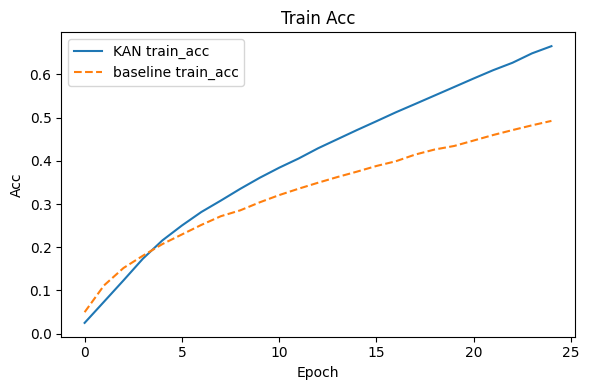

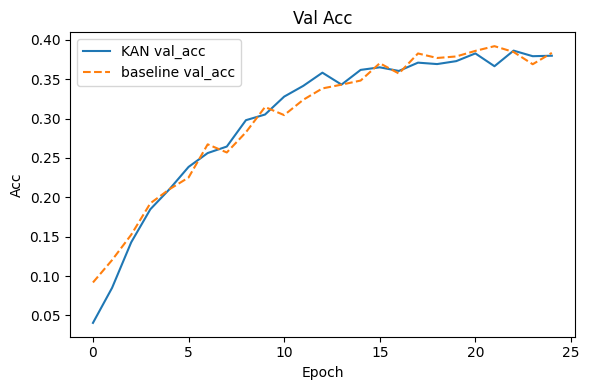

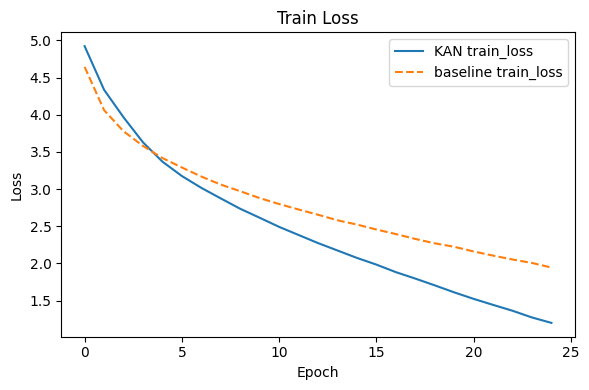

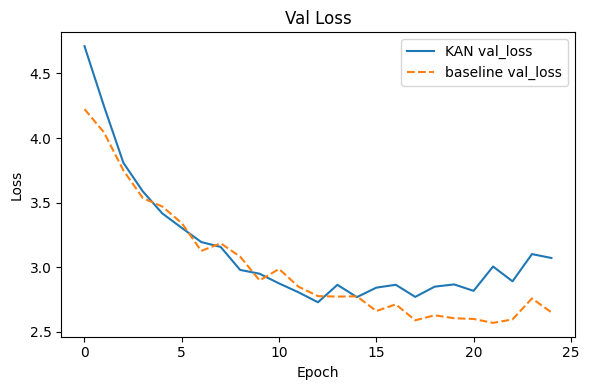

In [61]:
import json, itertools
from pathlib import Path
import matplotlib.pyplot as plt

def load_histories(run_dir: Path):
    out = {}
    for f in run_dir.glob("*_history.json"):
        name = f.stem.replace("_history", "")
        with open(f) as j:
            out[name] = json.load(j)
    return out

def plot_metrics(histories: dict[str, dict[str, list]],
                 metrics=("train_acc", "val_acc"),
                 styles=("solid", "dashed")):

    for m in metrics:
        plt.figure(figsize=(6,4))
        for name, style in zip(histories, itertools.cycle(styles)):
            plt.plot(histories[name][m], linestyle=style, label=f"{name} {m}")
        plt.title(m.replace("_", " ").title())
        plt.xlabel("Epoch")
        plt.ylabel(m.split("_")[-1].title())  # acc / loss
        plt.legend()
        plt.tight_layout()
        plt.show()
        
# ---------- usage -----------------
histories = load_histories(RUN_DIR)
plot_metrics(histories,
             metrics=("train_acc", "val_acc", "train_loss", "val_loss"))

#### Metrics

In [64]:
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    total_size = param_size + buffer_size  # Bytes
    return total_size / (1024 * 1024)

def plot_confusion_matrix(model: nn.Module,
                          test_loader: DataLoader,
                          title='Confusion Matrix'):
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import numpy as np
    
    # Determine device and make sure model is on that device
    device = next(model.parameters()).device
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            # Move data to the SAME device as the model
            images = batch["image"].to(device)
            labels = batch["label"].to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    # For large confusion matrices (like 200x200 for Tiny-ImageNet),
    # consider plotting a smaller version or using a different visualization
    plt.figure(figsize=(12, 10))
    
    # If matrix is large, disable annotations
    if cm.shape[0] > 20:
        sns.heatmap(cm, cmap='Blues', annot=False)
    else:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # Return something other than the plot object
    return "Successfully"

def calculate_stats(model, input_shape=(3, 64, 64)):
    # Get model memory size
    model_size = get_model_size(model)
    
    
    # Get complexity info as raw numbers
    macs, params = get_model_complexity_info(
        model, 
        input_shape, 
        as_strings=False,  # Get raw numbers
        print_per_layer_stat=False,  
        verbose=False
    )
    
    # Convert to appropriate units
    macs_gflops = macs * 2 / 1e9  # Convert MACs to GFLOPs (1 MAC ≈ 2 FLOPs)
    params_m = params   # Convert params to millions
    
    # Calculate inference time (optional)
    if hasattr(model, 'to') and torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        
    # Create a sample input
    sample_input = torch.randn(1, *input_shape).to(device)
    model = model.to(device).eval()
    
    # Warm-up
    with torch.no_grad():
        for _ in range(10):
            _ = model(sample_input)
    
    # Measure time
    if device.type == "cuda":
        torch.cuda.synchronize()
    elif device.type == "mps":
        torch.mps.synchronize()
        
    start_time = time.time()
    with torch.no_grad():
        for _ in range(100):
            _ = model(sample_input)
            
    if device.type == "cuda":
        torch.cuda.synchronize()
    elif device.type == "mps":
        torch.mps.synchronize()
        
    end_time = time.time()
    avg_inference_time = (end_time - start_time) / 100 * 1000  # ms
    
    return model_size, macs_gflops, params_m, avg_inference_time

In [65]:
b_model_size, b_macs_gflops, b_params_m, b_avg_inference_time = calculate_stats(baseline)
k_model_size, k_macs_gflops, k_params_m, k_avg_inference_time = calculate_stats(kan)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


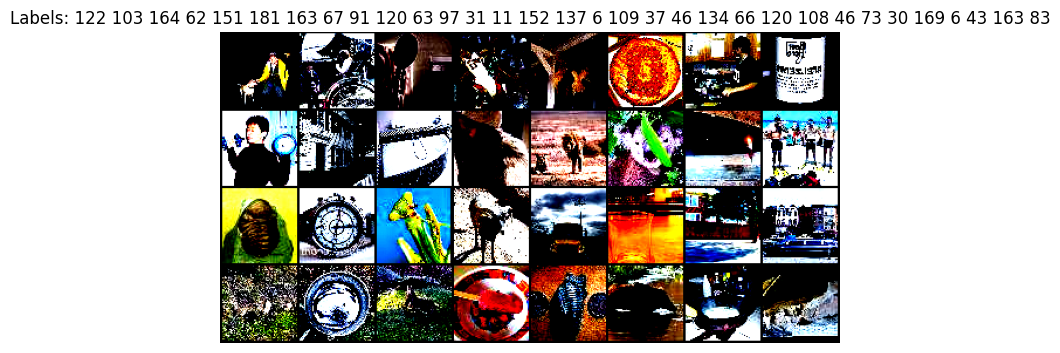

In [27]:
batch = next(iter(train_loader))
images  = batch["image"]                          # shape (B, 3, H, W)
labels  = batch["labels"] if "labels" in batch else batch["label"]

grid = make_grid(images[:32], nrow=8, padding=2)  # (3, H’, W’)

npimg = grid.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(8, 8))
plt.imshow(npimg)
plt.axis("off")
plt.title("Labels: " + " ".join(str(x) for x in labels[:32].tolist()))
plt.show()


      Model: MLP-based CNN
      Size: 7.751 MB
      Inference FLOPS: 2.70
      Number of parameters: 2029960
      Avg Inference time: 0.66 ms
      Confusion Matrix of KAN-based CNN: Plotted Successfully
      

      Model: B-Spline-based CNN
      Size: 7.126 MB
      Inference FLOPS: 0.47
      Number of parameters: 1866142
      Avg Inference time: 2.41 ms
      Confusion Matrix of KAN-based CNN: Plotted Successfully
      


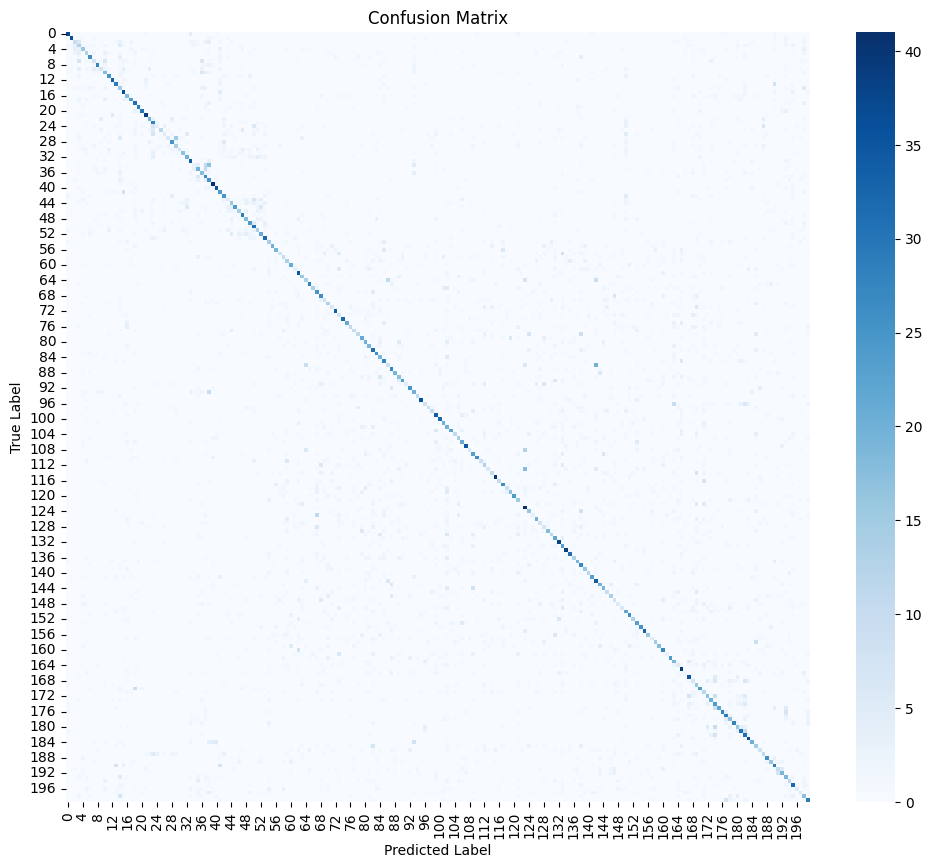

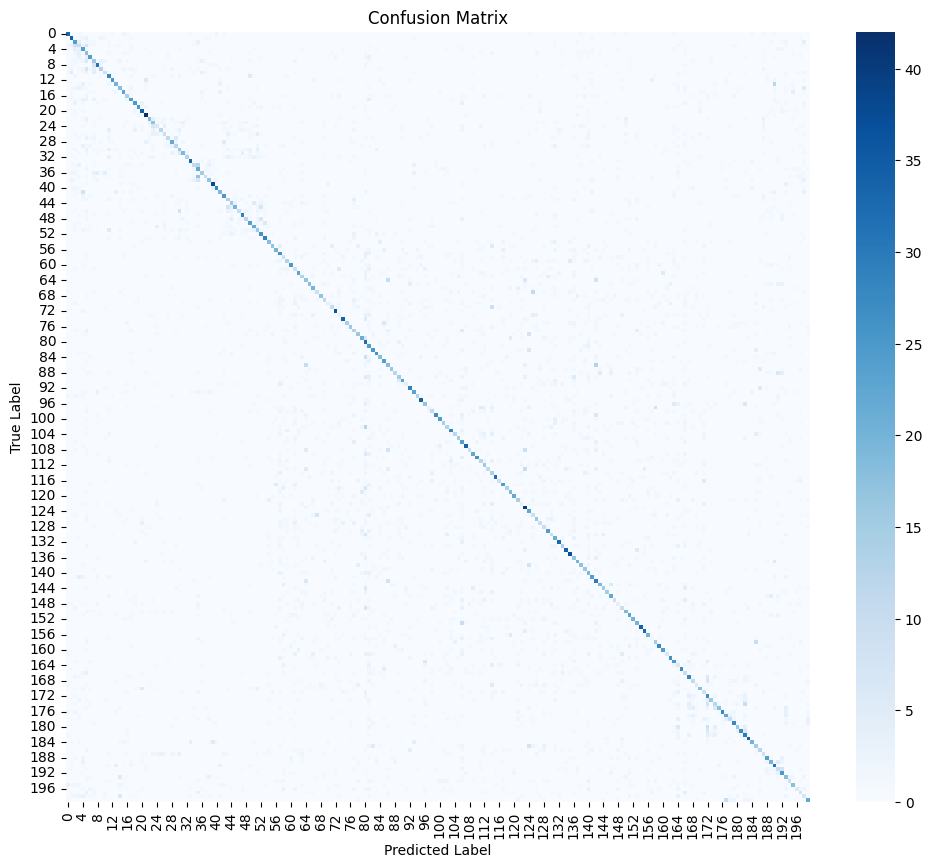

In [68]:
print(f"""
      Model: MLP-based CNN
      Size: {(b_model_size):.3f} MB
      Inference FLOPS: {b_macs_gflops:.2f}
      Number of parameters: {b_params_m}
      Avg Inference time: {b_avg_inference_time:.2f} ms
      Confusion Matrix of KAN-based CNN: Plotted {plot_confusion_matrix(baseline, test_loader=test_loader)}
      """)

print(f"""
      Model: B-Spline-based CNN
      Size: {(k_model_size):.3f} MB
      Inference FLOPS: {k_macs_gflops:.2f}
      Number of parameters: {k_params_m}
      Avg Inference time: {k_avg_inference_time:.2f} ms
      Confusion Matrix of KAN-based CNN: Plotted {plot_confusion_matrix(kan, test_loader=test_loader)}
      """)



### Optimize KAN

In [37]:
pbounds = {
    # ints → we pass floats in but will round later
    "epochs":             (6, 12),
    "kan_1":          (50, 100),   # width of first KAN layer
    "kan_2":          (50, 100),   # second KAN layer
    "kan_3":            (50, 100),
    "spline_cp":          (8, 12),      # control points
    "spline_deg":         (5, 7),      # deg ≤ cp‑1 guard enforced later
    "range_min":          (-2.0, -0.5),
    "range_max":          (40.0, 80.0),
    "lr":                 (1e-4, 1e-2)
}

import time
from tqdm.auto import tqdm

def train_kan(model, train_loader, val_loader, epochs, lr):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optim     = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)

    best_val = 0.0
    for ep in range(1, epochs + 1):
        tic = time.time()
        # ─ train ─
        model.train()
        loss_sum = acc_sum = 0.0
        for batch in train_loader:
            x, y = batch["image"].to(device), batch["label"].to(device)
            optim.zero_grad(set_to_none=True)
            logits = model(x)
            loss   = criterion(logits, y)
            loss.backward()
            optim.step()

            acc = (logits.argmax(1) == y).float().mean().item()
            loss_sum += loss.item() * x.size(0)
            acc_sum  += acc * x.size(0)

        # ─ eval ─
        model.eval()
        loss_sum_val = acc_sum_val = 0.0
        with torch.no_grad():
            for batch in val_loader:
                x, y = batch["image"].to(device), batch["label"].to(device)
                logits = model(x)
                loss   = criterion(logits, y)
                acc    = (logits.argmax(1) == y).float().mean().item()
                loss_sum_val += loss.item() * x.size(0)
                acc_sum_val  += acc * x.size(0)

        train_loss = loss_sum     / len(train_loader.dataset)
        train_acc  = acc_sum      / len(train_loader.dataset)
        val_loss   = loss_sum_val / len(val_loader.dataset)
        val_acc    = acc_sum_val  / len(val_loader.dataset)
        elapsed    = time.time() - tic

        # ← print exactly like you had it
        print(f"Epoch [{ep}/{epochs}], "
              f"Loss: {train_loss:.4f}, "
              f"Test Acc: {val_acc*100:5.2f}%, "
              f"Time: {elapsed:5.2f} seconds")

        best_val = max(best_val, val_acc)

    return best_val


def optimize_kan(epochs,
                 kan_1,
                 kan_2,
                 kan_3,
                 spline_cp,
                 spline_deg,
                 range_min,
                 range_max,
                 lr):

    # ─ cast + sanity ─
    epochs      = int(round(epochs))
    kan_1   = int(round(kan_1))
    kan_2   = int(round(kan_2))
    kan_3   = int(round(kan_3))
    spline_cp   = int(round(spline_cp))
    spline_deg  = int(round(spline_deg))

    # keep B‑spline well‑formed
    spline_deg  = max(2, min(spline_deg, spline_cp - 1))
    lr          = float(lr)

    model = KANCNN(
        kan_1=kan_1,
        kan_2=kan_2,
        kan_3=kan_3,
        spline_cp=spline_cp,
        spline_deg=spline_deg,
        range_min=range_min,
        range_max=range_max
    )
    
    k_model_size, k_macs_gflops, k_params_m, k_avg_inference_time = calculate_stats(model)
    print(f"""
        \n
        --------------
        Model: B-Spline-based CNN
        Size: {(k_model_size):.3f} MB
        Inference FLOPS: {k_macs_gflops:.2f}
        Number of parameters: {k_params_m:.2f} Million
        Avg Inference time: {k_avg_inference_time:.2f} ms
        --------------
        \n
          """)
    val_acc = train_kan(model, train_loader, val_loader, epochs, lr)

    # BayesOpt maximizes the returned value
    return val_acc



In [38]:


optimize_by_input = input("Would you like to optimize for the KAN? y/n")
if optimize_by_input == "y":
    optimizer = BayesianOptimization(
        f=optimize_kan,
        pbounds=pbounds,
        random_state=38,
        verbose=2
    )

    optimizer.maximize(init_points=1, n_iter=24)

    print("Best combo so far →", optimizer.max)
else:
    print("No optimization applied.")

|   iter    |  target   |  epochs   |   kan_1   |   kan_2   |   kan_3   |    lr     | range_max | range_min | spline_cp | spline... |
-------------------------------------------------------------------------------------------------------------------------------------

        

        --------------
        Model: B-Spline-based CNN
        Size: 6.242 MB
        Inference FLOPS: 0.47
        Number of parameters: 1.63 Million
        Avg Inference time: 5.81 ms
        --------------
        

          
Epoch [1/8], Loss: 5.1192, Test Acc:  1.94%, Time: 50.30 seconds
Epoch [2/8], Loss: 4.6678, Test Acc:  5.98%, Time: 49.40 seconds
Epoch [3/8], Loss: 4.2471, Test Acc:  9.35%, Time: 49.45 seconds
Epoch [4/8], Loss: 4.0216, Test Acc: 11.22%, Time: 48.88 seconds
Epoch [5/8], Loss: 3.7497, Test Acc: 14.23%, Time: 49.44 seconds
Epoch [6/8], Loss: 3.5500, Test Acc: 17.65%, Time: 49.51 seconds
Epoch [7/8], Loss: 3.3853, Test Acc: 21.36%, Time: 49.62 seconds
Epoch [8/8], Loss: 3.2339, Test A